# 3 Seminar
Hi! Today we are going to learn Catalyst Framework and CNN.

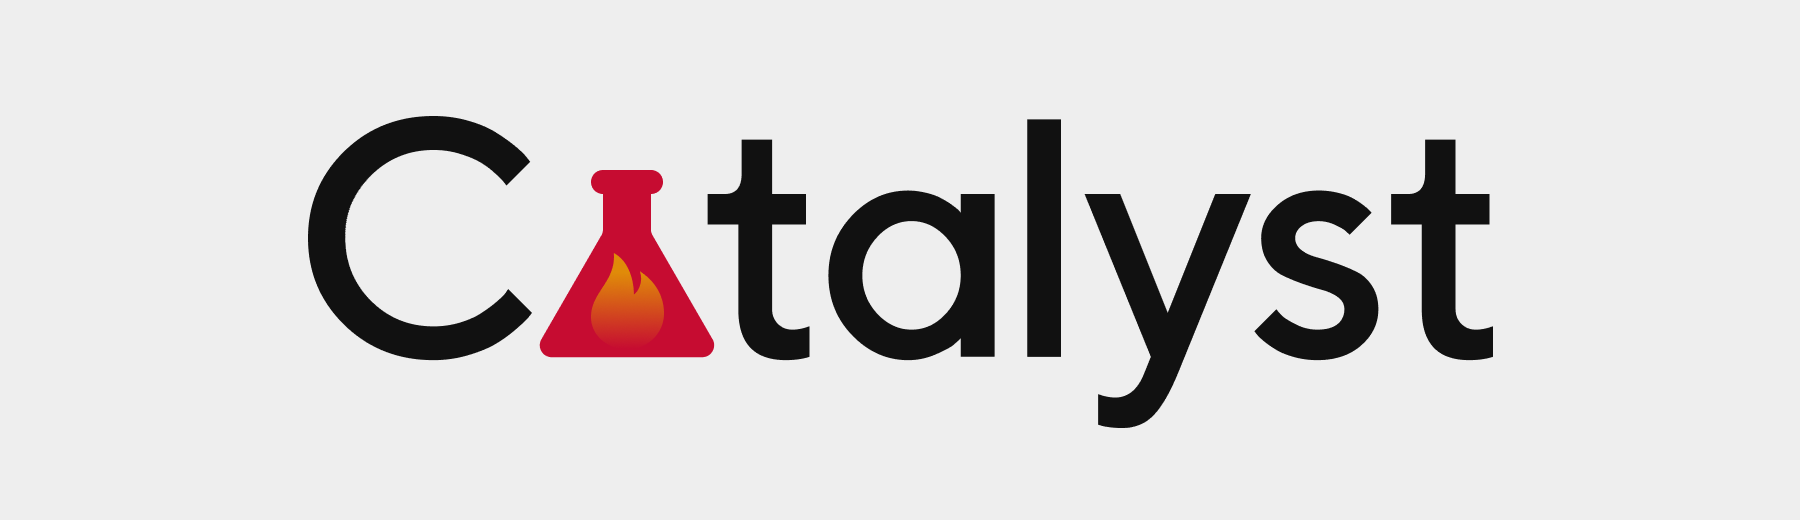

In [ ]:
!pip install catalyst

In [ ]:
from catalyst import utils

In [ ]:
utils.set_global_seed(42)

## MNIST Example (AGAIN(?!))

Let's continue getting to know with the Catalyst. Recall previous example: train small network on the MNIST dataset.

In [ ]:
from datetime import datetime
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from catalyst import dl
from catalyst.data.cv import ToTensor
from catalyst.contrib.datasets import MNIST
from catalyst.utils import metrics

model = torch.nn.Linear(28 * 28, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

loaders = {
    "train": DataLoader(
        MNIST(os.getcwd(), train=True, download=True, transform=ToTensor()),
        batch_size=32,
    ),
    "valid": DataLoader(
        MNIST(os.getcwd(), train=False, download=True, transform=ToTensor()),
        batch_size=32,
    ),
}


class CustomRunner(dl.Runner):

    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))

    def _handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_hat = self.model(x.view(x.size(0), -1))

        loss = self.criterion(y_hat, y)
        accuracy01, accuracy03 = metrics.accuracy(y_hat, y, topk=(1, 3))
        self.batch_metrics.update(
            {"loss": loss, "accuracy01": accuracy01, "accuracy03": accuracy03}
        )

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

runner = CustomRunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    loaders=loaders,
    criterion=criterion,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=5,
    verbose=True,
    load_best_on_end=True,
)
# model inference
for prediction in runner.predict_loader(loader=loaders["valid"]):
    assert prediction.detach().cpu().numpy().shape[-1] == 10
# model tracing
traced_model = runner.trace(loader=loaders["valid"])

In [ ]:
# Do you forget about logging?

%load_ext tensorboard
%tensorboard --logdir logs

We can use callbacks to simplify our code. Let catalyst calculate loss and optimize model parameters. To do this, we will use callbacks!
And we'll enhance the model and the task. Catalyst has useful tools to create model, improve training and etc. These tools were added by contributors. Because the tools aren't connected with main Catalyst functional, they sit in catalyst.contrib.


In [ ]:
from catalyst.contrib.nn.optimizers import Lookahead
from catalyst.contrib.nn.criterion import FocalLossMultiClass
from catalyst.contrib.models import SequentialNet

model = SequentialNet(...)
optimizer = ...
criterion = ...


class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))

    def _handle_batch(self, batch):
        x, y = batch
        y_pred = self.model(x.view(x.size(0), -1))
        self.input = ...
        self.output = ...


runner = CustomRunner()
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=5,
    verbose=True,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(num_classes=10),
    },
)
traced_model = runner.trace(loader=loaders["valid"])

## CNN



### Convolution

To understand convolutional neural network, we start with main operation – convolute. Choose the victim (cat picture) and the knife (kernels from pretrained model). Look which picture region have maximum activation (white pixels). How output correspond with input?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

In [ ]:
!wget http://placekitten.com/200/300 -O cat.jpg

In [ ]:
from PIL import Image

image = Image.open("cat.jpg")
fig, ax = plt.subplots(figsize=(18, 8))
ax.imshow(image)

AlexNet is the perfect model for demonstration. It has big kernels in the begging, and they compute easy-to-understand feature pics.

In [ ]:
# Print all feature modules and find first layer convolution kernels

model = models.alexnet(pretrained=True)
print(
    "\n".join(
        f"Name: {n}, module:{m}"
        for n, m in ...
    )
)

Show the starting kernels.

In [ ]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    w = model.features[0].weight[i].detach().numpy()[0]
    w = (w - w.min()) / (w.max() - w.min())
    ax[i // 5, i % 5].imshow(w, cmap="gray")

Try convolute operation with kernels, which have horizontal or vertical lines. They might have maximum activation in specific regions.

In [ ]:
from scipy import signal


def convolute(w):
    """
    Quick written function for showing convolution results
    """
    new_image = ... # convolve image with kernel
    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(np.array(image), cmap='gray')
    ax[2].imshow(new_image, cmap='gray')
    ax[1].imshow(w, cmap='gray')

In [ ]:
convolute(model.features[0].weight[3].detach().numpy()[0])

In [ ]:
convolute(model.features[0].weight[4].detach().numpy()[0])

In [ ]:
convolute(model.features[0].weight[0].detach().numpy()[0])

### CIFAR & ResNet

Next we are going to create a model with ResNet architecture [arxiv](https://arxiv.org/abs/1512.03385). This architecture has important techniques, which are used in a lot of models (Residual connections) and resnet models are easy to impolement and train.

We have to do some changes in the model. The first convolutional layer has smaller kernel size (3 vs 7) and stride (1 vs 3). A MaxPool layer is deleted from our implementation.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision.transforms as transforms

from datetime import datetime
import os
from pathlib import Path
from torch.nn import functional as F
from catalyst import dl
from catalyst.data.cv import ToTensor
from catalyst.contrib.datasets import MNIST
from catalyst.utils import metrics

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, p=0.1):
        super().__init__()

        self.input = nn.Sequential(
            ...
        )
        self.res = nn.Conv2d(
            ...
        )
        self.output = nn.Sequential(
            ...
        )

    def forward(self, x):
        return ...


class ResNet18(nn.Module):
    def __init__(self, channels=3, in_features=64, num_classes=10, p=0.1):
        super().__init__()

        self.input = nn.Sequential(
            ...
        )

        self.layer_0 = self._make_layer(in_features, 1)
        self.layer_1 = self._make_layer(in_features)
        in_features *= 2
        self.layer_2 = self._make_layer(in_features)
        in_features *= 2
        self.layer_3 = self._make_layer(in_features)

        self.fc = nn.Sequential(
            ...
        )

    def _make_layer(self, in_features, multiplier=2, p=0.1):
        return nn.Sequential(
            ResNetBlock(in_features, in_features * multiplier, stride=2, p=p),
            ResNetBlock(
                in_features * multiplier,
                in_features * multiplier,
                stride=1,
                p=p,
            ),
        )

    def forward(self, x):
        x = self.input(x)
        x = self.layer_0(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return self.fc(x)

Look at the pictures in CIFAR dataset. They're small(32x32 pix), but our ResNet will achive high accuracy in one train epoch.

In [ ]:
import matplotlib.pyplot as plt
import os


cifar_dataset = CIFAR10(os.getcwd(), train=True, download=True)

_, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax[i // 5, i % 5].imshow(cifar_dataset[i][0], cmap="gray")

Always normalize your data.

In [ ]:
cifar_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # ImageNet normalizer
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

loaders = {
    "train": DataLoader(
        CIFAR10(
            os.getcwd(), train=True, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
    "valid": DataLoader(
        CIFAR10(
            os.getcwd(), train=False, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
}

Define runner for the CIFAR task.

In [ ]:
class CIFARrunner(dl.Runner):

    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device))

    def _handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_pred = self.model(x)

        self.input = ...
        self.output = ...

Let's train our model!

In [ ]:
from catalyst.contrib.nn import Lookahead

model = ResNet18()
optimizer = Lookahead(torch.optim.Adam(model.parameters(), lr=1e-3))
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    verbose=True,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(num_classes=10),
    },
)

### Augmentations

Let's add images in CIFAR Dataset. Train and check the metrics! All augmentations can be found in [albumentations docs](https://albumentations.ai/docs/). We will use some of them.
Another cool augmentations viewer is: [click me!](https://albumentations-demo.herokuapp.com/)

Choose the victim in our image tranformation experiment.



In [ ]:
import albumentations as albu

def show_transform(transform):
    new_image = ... # transform image
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(new_image)

In [ ]:
show_transform(
    albu.ShiftScaleRotate(
        shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=1
    )
)

In [ ]:
show_transform(
    albu.RandomBrightnessContrast(
        brightness_limit=0.5, contrast_limit=0.5, p=1
    )
)

In [ ]:
show_transform(albu.RandomGamma(gamma_limit=(65, 145), p=1))

All transformation code below was copy-pasted from Catalyst examples: [link](https://colab.research.google.com/github/catalyst-team/catalyst/blob/master/examples/notebooks/classification-tutorial.ipynb#scrollTo=zbPxuvxTByFM)

In [ ]:
from albumentations.pytorch import ToTensor
import numpy as np


BORDER_CONSTANT = 0
BORDER_REFLECT = 2


def pre_transforms(image_size=32):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]

    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]

    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

Add augmentation in our dataset:

In [ ]:
class CIFAR10DatasetAugmented(Dataset):
    def __init__(self, transforms=None, train=True, download=False):
        self.data = CIFAR10(os.getcwd(), train=train, download=download)
        self.transforms = transforms

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return ...

    def __len__(self):
        return len(self.data)

train_transforms = compose([
    ...# compose train transformation
])
valid_transforms = compose([
    ...# compose valid transformation
])

In [ ]:
loaders = {
    "train": DataLoader(
        CIFAR10DatasetAugmented(
            train=True,
            download=True,
            transforms=train_transforms,
        ),
        num_workers=4,
        shuffle=True,
        drop_last=True,
        batch_size=256,
    ),
    "valid": DataLoader(
        CIFAR10DatasetAugmented(
            train=False,
            download=True,
            transforms=valid_transforms,
        ),
        num_workers=4,
        shuffle=False,
        drop_last=False,
        batch_size=256,
    ),
}

model = ResNet18()
optimizer = Lookahead(torch.optim.Adam(model.parameters(), lr=1e-3))
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    verbose=True,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(num_classes=10),
    },
)

To use Augmentation in Catalyst, we'll use Augmentor. For every item it will find features(in our case – an image) and transform it by our rule. It won't change anything else.

In [ ]:
from catalyst.data import Augmentor

# Takes an image from the input dictionary by the key `dict_key`
# and performs `train_transforms` on it.
train_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: train_transforms(image=x)["image"]
)


# Similarly for the validation part of the dataset.
# we only perform squaring, normalization and ToTensor
valid_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: valid_transforms(image=x)["image"]
)

In [ ]:
from catalyst.dl import utils

train_data = CIFAR10(os.getcwd(), train=True, download=True)
valid_data = CIFAR10(os.getcwd(), train=False, download=True)

train_loader = utils.get_loader(
    train_data,
    open_fn=lambda x: {"features": x[0], "target": x[1]},
    dict_transform=train_data_transforms,
    batch_size=256,
    num_workers=4,
    shuffle=True,
    drop_last=True,
)

valid_loader = utils.get_loader(
    valid_data,
    open_fn=lambda x: {"features": x[0], "target": x[1]},
    dict_transform=valid_data_transforms,
    batch_size=256,
    num_workers=4,
    shuffle=False,
    drop_last=True,
)

Retrain our model with new data pipelines.

In [ ]:
model = ResNet18()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    verbose=True,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(num_classes=10),
    },
)

### Attack(!)

Let's fool NeuralNetwork! Change image label from `<true label>` to `<any label your like>`.

In [ ]:
model = ... # choose pretrained model
optimizer = Lookahead(torch.optim.Adam(model.parameters(), lr=1e-3))
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    verbose=True,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(num_classes=10),
    },
)

In [ ]:
model.eval()

with torch.no_grad():
    prepared_image = ...# prepare image

    print(
        f"It's a {cifar_dataset.classes[model(prepared_image.cuda()).max(1)[1]]}"
    )

Usually the model predict true label. Lets add some noise to the image to fool the model. Instead of aa cat it must saw a deer.

In [ ]:
cifar_dataset.class_to_idx

In [ ]:
from tqdm.notebook import tqdm


with torch.no_grad():
    prepared_image = ... # prepare image
noise = ... # generate noise
lr = 1000

pbar = tqdm(range(1000), desc=f"Loss: {0}")
for i in pbar:
    noise.grad = None # Empty gradients

    # Generate new image
    new_image = ...
    preds = model(new_image.cuda())[0, :10]

    # Try to fool the model
    loss = ...  # Cross Entropy Loss on wrong label!

    # Optimize noise
    loss.backward()
    with torch.no_grad():
        noise -= noise.grad * lr

    pbar.set_description(f"Loss: {loss}")

Check our work.

In [ ]:
model.eval()

with torch.no_grad():
    prepared_image = ... # prepared image plus noise

    print(f"It's a {cifar_dataset.classes[model(prepared_image.cuda())[0, :10].max(0)[1]]}")

Let's look at the noised picture.

In [ ]:
prepared_image = ... # prepared image plus noise

_, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(np.array(image), cmap="gray")
ax[1].imshow(
    noise.squeeze(0).permute(1, 2, 0).detach().cpu().numpy(), cmap="gray"
)
ax[2].imshow(prepared_image.detach().numpy(), cmap="gray")